In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import gudhi as gh

from src.depth import DepthPoset

from matplotlib import pyplot as plt

import itertools

In [3]:
# border

In [4]:
def iterate_cubical_cells(shape, k=None, process=None):
    """
    Generate all k-dimensional hypercubes (as sets of 2^(dim-k) vertex indices) 
    in a regular grid of the specified shape.

    This function iterates over all axis-aligned k-dimensional hypercubes 
    embedded in a grid of a given shape. Each hypercube is represented by the 
    indices of its 2^(dim-k) corner points.

    Parameters
    ----------
    shape : tuple of int
        The shape of the grid. Each entry corresponds to the number of points 
        along that dimension.
    k : int or None, optional
        The dimension of the hypercubes to iterate over. If `k` is None, iterate 
        over all dimensions from 0 to len(shape) (inclusive).
    process : callable or None, optional
        A function to apply to each set of indices before yielding. It should 
        accept a NumPy array of shape (2^(dim-k), dim) and return a modified 
        version of it.

    Yields
    ------
    element : tuple of tuples of int
        A tuple representing a set of indices corresponding to the 2^(dim-k) 
        vertices of a k-dimensional hypercube in the grid. Each vertex is 
        represented as a tuple of coordinates.

    Notes
    -----
    - The function uses axis-aligned combinations of directions to define hypercubes.
    - Each k-dimensional hypercube lies in a (dim-k)-dimensional affine subspace 
      of the grid.
    - The yielded elements can be used to define cells (e.g., edges, squares, 
      cubes) in a cubical complex.

    Examples
    --------
    >>> list(iterate_neigboring_index((2, 2), k=1))
    [((0, 0), (1, 0)), ((0, 1), (1, 1)),
     ((0, 0), (0, 1)), ((1, 0), (1, 1))]
    >>> list(iterate_neigboring_index((2, 2), k=0))
    [((0, 0),), ((1, 0),), ((0, 1),), ((1, 1),)]
    """
    dim = len(shape)
    if k is None:
        for k in range(0, dim + 1):
            for element in iterate_cubical_cells(shape, k=k):
                yield element
            
    for shifting in itertools.combinations(np.arange(dim), dim - k):
        shifts = np.zeros([2**(dim - k), dim], dtype=int)
        shifts[:, list(shifting)] = list(itertools.product([0, 1], repeat=dim - k))

        current_shape = np.array(shape)
        current_shape[list(shifting)] -= 1
        current_shape = tuple(current_shape)
        for idx in np.ndindex(current_shape):
            element = shifts + np.array(idx)
            if process is not None:
                element = process(element)    
            element = tuple([tuple([int(i) for i in e]) for e in element])
            yield element

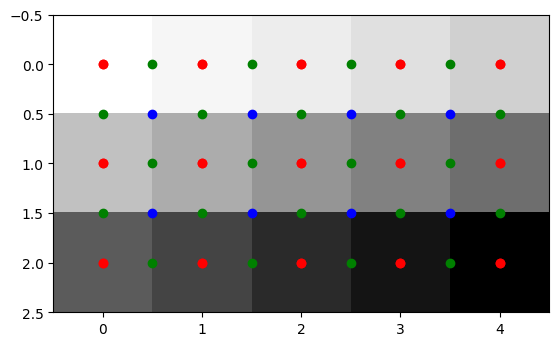

In [5]:
heights = np.linspace(0, 1, 15).reshape([3, 5])

fig, ax = plt.subplots()

ax.imshow(heights, cmap='Greys')
    
for idx in iterate_cubical_cells(heights.shape):
    color = int(np.log(len(idx))/np.log(2))
    color = ['red', 'green', 'blue'][color]
    y, x = np.array(idx).mean(axis=0)
    ax.scatter(x, y, color=color)

In [6]:
def get_ordered_border_matrix_from_heights(heights, mode='simple'):
    """
    Returns the border matrix of complex of square cells, given in the matrix
    
    Parameters:
    -----------
    heights: np.ndarray
        The matrix 

    mode: str
        ...

    Returns:
    --------
    sources: np.ndarray of tuples
        The cells description: the indices of heights matrix coresponding the cell

    matrix: 2-dimensional np.ndarray dtype bool
        Border matrix
        
    dims: np.ndarray dtype int
        The cells dimensions
        
    filtration: np.ndarray dtype float
        The filtration values

    """
    heights = np.asarray(heights)
    dim = heights.ndim

    # define source cells
    if mode.lower() == 'simple':
        sources = np.array(list(iterate_cubical_cells(heights.shape, k=None, process=None)), dtype=object)
    elif mode.lower() == 'torus':
        pass
        raise ValueError(f"Mode {mode.__repr__()} is not realised yet.")
    else:
        raise ValueError(f"Unexpected mode: {mode.__repr__()}")

    # define their dimension and filtration values
    dims = np.array([dim - np.log(len(source))/np.log(2) for source in sources]).astype(int)
    filtration = np.array([min([heights[idx] for idx in source]) for source in sources])

    # reorder
    reorder = np.lexsort((dims, filtration))
    sources = sources[reorder]
    dims = dims[reorder]
    filtration = filtration[reorder]

    # border matrix
    matrix = np.zeros([len(sources), len(sources)], dtype=bool)
    for i, j in itertools.product(range(len(dims)), repeat=2):
        matrix[i, j] = (dims[i] == dims[j] - 1) & (set(sources[i]) & set(sources[j]) == set(sources[j]))
    
    return sources, matrix, dims, filtration

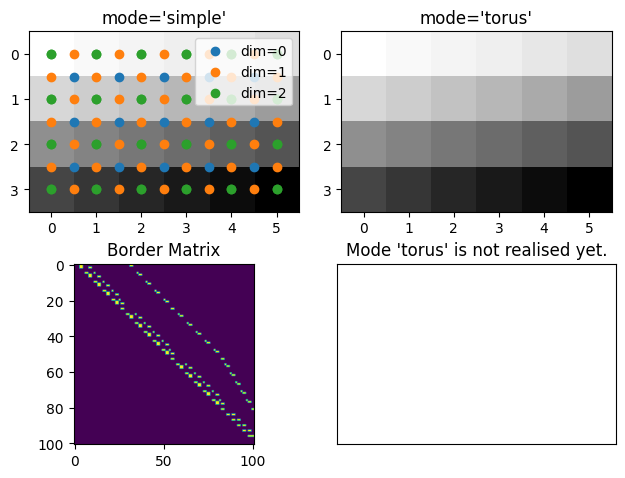

In [7]:
heights = np.linspace(0, 1, 24).reshape([4, 6])


modes = ['simple', 'torus']

fig, axs = plt.subplots(2, len(modes))

for i, mode in enumerate(modes):
    axs[0, i].set_title(f'mode={mode.__repr__()}')
    axs[0, i].imshow(heights, cmap='Greys')
    
    try:
        sources, matrix, dims, filtration = get_ordered_border_matrix_from_heights(heights, mode=mode)
        
        for idim, dim in enumerate(np.unique(dims)):
            y, x = np.array(list(sources[dims == dim])).mean(axis=1).transpose()
            axs[0, i].scatter(x, y, label=f'dim={dim}')
        axs[0, i].legend()
        
        axs[1, i].set_title(f'Border Matrix')
        axs[1, i].imshow(matrix)
    except Exception as err:
        axs[1, i].set_title(err)
        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])

plt.tight_layout()
plt.show()